# Import Libraries and Modules

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM
from keras.layers import Dropout
import yfinance as yf
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta

# Data Retrieval



# Read CSV's

In [135]:
#load data from yfinance

# Set the desired ASX stock symbol
symbol = "bhp.AX"

# Define the date range for historical data
start_date = "2010-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")

# Download historical stock data using yfinance
data = yf.download(symbol, start=start_date, end=end_date)

# Convert to Data Frame
bhp = pd.DataFrame(data)


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,39.947372,40.423939,39.909992,40.255737,19.880648,3949861
2010-01-05,40.648205,40.779026,40.395905,40.442627,19.972954,9721826
2010-01-06,40.722958,40.975258,40.685581,40.947224,20.222158,6951354
2010-01-07,41.031322,41.246246,40.881813,40.900501,20.199080,7091269
2010-01-08,40.825748,40.993946,40.648205,40.760338,20.129858,4906718


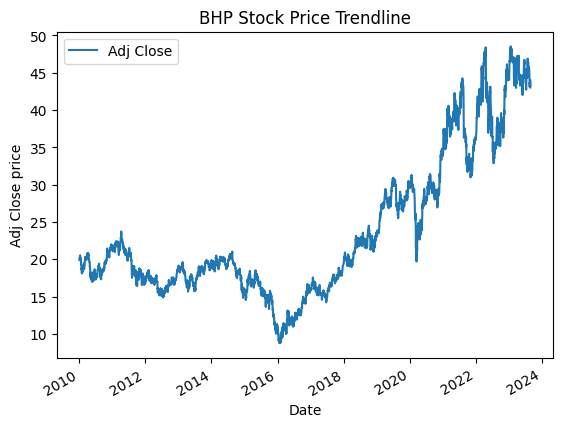

In [136]:
#BHP sample data and trendline visualization
display(bhp.head())
df_s = bhp.drop(columns = ['Open','High', 'Low', 'Close', 'Volume'])
plot = df_s.plot(title="BHP Stock Price Trendline")
plot.set_xlabel("Date")
plot.set_ylabel("Adj Close price")
plt.show()

In [137]:
#Check shpae of the data
print("BHP selected data has rows : {} and cloumns : {} ".format(bhp.shape[0], bhp.shape[1]))


BHP selected data has rows : 3450 and cloumns : 6 


In [138]:
#checking for nyuull values
print("BHP data has missing values : {}".format(bhp.isnull().values.any()))


BHP data has missing values : False


In [139]:
# Display info
display(bhp.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3450 entries, 2010-01-04 to 2023-08-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3450 non-null   float64
 1   High       3450 non-null   float64
 2   Low        3450 non-null   float64
 3   Close      3450 non-null   float64
 4   Adj Close  3450 non-null   float64
 5   Volume     3450 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 188.7 KB


None

In [140]:
#vStatistical values
print("BHP - Statistics:")
display(bhp.describe())


BHP - Statistics:


,Open,High,Low,Close,Adj Close,Volume
count,3450.000000,3450.000000,3450.000000,3450.000000,3450.000000,3.450000e+03
mean,34.464863,34.709914,34.205271,34.454358,23.584141,9.654942e+06
std,7.789778,7.828379,7.743033,7.784895,9.528315,7.532299e+06
min,14.150000,14.460000,14.060000,14.200000,8.751181,0.000000e+00
25%,29.814011,30.063236,29.581104,29.818519,17.062302,6.109337e+06
50%,34.649090,34.868683,34.382772,34.625528,19.750154,8.276642e+06
75%,39.465001,39.747949,39.237198,39.537500,28.981161,1.150085e+07
max,54.040001,54.549999,53.610001,54.060001,48.519943,3.274170e+08


# Correlation Analysis
In statistical analysis correlation is nothing but relation between variables. If correlation coefficient is positive correlated then both the values are moving in one direction, if coefficient is exactly one it is called perfect positive correlation. In other way negative correlated values moves in different direction.
Coefficient fluctuates in between -1 and 1, 0 means no realtion.

<Axes: title={'center': 'Correlation of BHP with Adj Close'}>

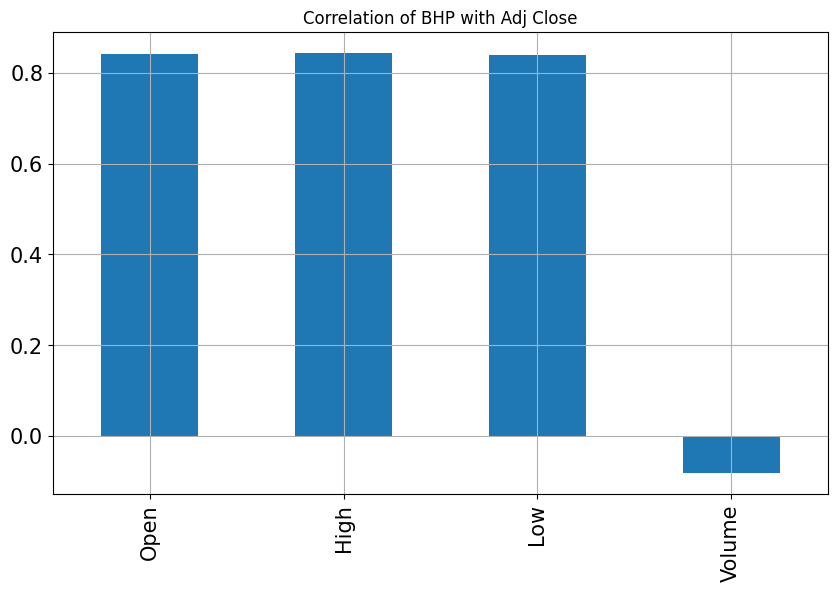

In [141]:
#correlating adj_close to other columns
#droping adj_close and close columns
s = bhp.drop(columns=['Adj Close', 'Close'], axis=1)
s.corrwith(bhp['Adj Close']).plot.bar(
                figsize = (10, 6), title = "Correlation of BHP with Adj Close", fontsize = 15,
                rot = 90, grid = True)

<Axes: >

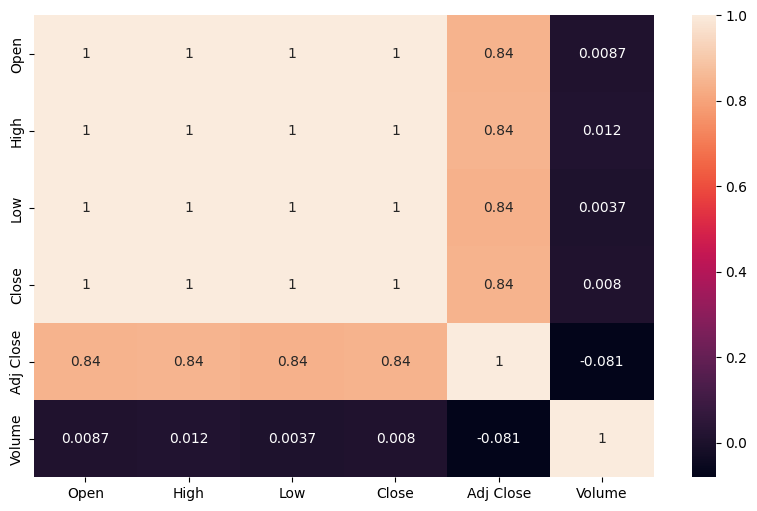

In [142]:
# Plotting Correlation Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(bhp.corr(), annot = True)

In [143]:
matrix_corr = bhp.corr()
coef = matrix_corr['Adj Close'].sort_values(ascending=False)

In [144]:
#Possitively correleated values
possitive_corr = coef[coef>0]
possitive_corr

Adj Close    1.000000
High         0.844195
Close        0.841516
Open         0.841134
Low          0.839247
Name: Adj Close, dtype: float64

In [145]:
#Negatively correlated values
negative_corr = coef[coef<0]
negative_corr

Volume   -0.081224
Name: Adj Close, dtype: float64

# 3 Technical indicators
    # Relative Strength Index
    # Simple Mean Average
    # Standard Deviation
  



In [146]:
#Technical indicatiors methods
def get_RSI(df, periods=14):
    """
    Method is used to calculate the RSI
    args:
        df: Adj Close price of the dataframe
        periods: Standard periods to calcualte initial value is 14
    return:
        rsi: function returns the relative strength index of given input.
    ewm = exponential moving average
    """
    # wilder's RSI
    delta = df.diff()
    up, down = delta.copy(), delta.copy()

    up[up < 0] = 0
    down[down > 0] = 0

    rollUp = up.ewm(com=periods,adjust=False).mean()
    rollDown = down.ewm(com=periods, adjust=False).mean().abs()

    RSI = 100 - 100 / (1 + rollUp / rollDown)

    return RSI


def get_SMA(df, peroids=15):
    """
     It takes a window size of periods at a time and perform mathematical operation on it.
     A window of size periods means periods consecutive values at a time.
    args:
        df: Adj Close price of the dataframe
        periods: Standard observation used for calculation
    return:
        SMA : calcualtes simple moving average
    """
    SMA = df.rolling(window=peroids, min_periods=peroids, center=False).mean()

    return SMA

def get_STDEV(df, periods=5):
    """
    args:
        df: Adj Close price of the dataframe
        periods: Standard observation used for calculation
    return:
        STDEV: calcualtes the standard deviation
    """
    STDEV = df.rolling(periods).std()

    return STDEV



In [147]:
# calculates Technical indicators for the given dataframe
# final_df = pd.DataFrame()
def calc_Tech_ind_add_col(df, original_df):
    """
    calculates all the technical indicators and assigned to new variable
    add new columns to the dataframe with technical indicators.
    args:
        df : Adj Close price of the dataframe
        original_df : original dataframe of the stock
    return :
        final_df:  final dataframe with technical indicators in that
    """
    print("Calculating technical indicators of given stock price")


    final_df = original_df

    final_df['RSI'] = get_RSI(df)
    print("RSI column added")
    final_df['SMA'] = get_SMA(df)
    print("SMA column added")
    final_df['STDEV'] = get_STDEV(df)
    print("STDEV column added")


    return final_df




# Normalize the Data

In [148]:
# In this step I would perform feature scaling/normalization of feature variables using sklearn's MinMaxScaler function.
def normalize_featuresDF(df):
    """
    It performs scaling/normalization of the feature columns using sklearn's MinMazScaler function.
    Range format is from 0 to 1
    args:
        df : featuers columsn datafrane
    return:
        normalized_features_df : normalized data frame ..

    """
    scaler = MinMaxScaler()
    feature_columns = df.columns
    feature_minmax_data = scaler.fit_transform(df)
    normalized_features_df = pd.DataFrame(columns=feature_columns, data=feature_minmax_data, index=df.index)


    return normalized_features_df


   # Split validation set from complete data

In [149]:
def split_ValidationSet(features_df, target_df, length=90):
    """
    method is to separate validation set from the complete df
    args:
        features_df: full features_df
        target_df :  full target_dt
        length: prediction length
    returns :
        validation_x : returns features validations sets
        validation_y : returns target validations sets
    """
    #need to shift target array because we are prediction n + 1 days price
    target_df = target_df.shift(-1)
    #split validation set . i am spliting 10% latest data for validation.
    #target
    validation_y = target_df[-length:-1]
    validation_x = features_df[-length:-1]

    return validation_x, validation_y

#Now get final_features_df and final_target_df by excluding validation set
def split_Final_df(normalized_features_df, target_df, v_length=90):
    """
    This method will be having remaining data after the validation set.
    args:
        features_df: normalized features_df
        target_df: complete target_df
        v_length: validation set length
    return:
        final_features_df : set of feature df excluding validation set
        final_target_df : set of target df excluding validation set
    """
    final_features_df = normalized_features_df[:-v_length]
    final_target_df = target_df[:-v_length]

    return final_features_df, final_target_df

#  Train and Test split using Sklearn's Timeseries split

In [150]:
#Split final set into training and testing sets
#splitting training and testing set using sklearn's TimeSeries split
def split_Train_Test_DF(final_features_df, final_target_df, n_splits=10):
    """
    Using sklearn's timeseries split to split the training and testing sets
    args:
        final_features_df: features_df after splitting validation set
        final_target_df: target_df after splitting validation set

    return:
        x_train : traing feature set
        y_train : training target set
        x_test : testing feature set
        y_test : testing target set
    """
    ts_split = TimeSeriesSplit(n_splits)
    for train_index, test_index in ts_split.split(final_features_df):
        x_train, x_test = final_features_df[:len(train_index)], final_features_df[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = final_target_df[:len(train_index)].values.ravel(), final_target_df[len(train_index): (len(train_index)+len(test_index))].values.ravel()

    return x_train, y_train, x_test, y_test


#  Visualizing the datasets

In [151]:
def plot_3DataSets():
    """
    Method displays the plot of the 3 different sets into single plot.
    This is just for sanity check.
    This is time series data so, sets should not be mixed.

    """
    t=y_test.astype(np.float)
    v = target_df[-90:-1].values.ravel()
    plt.plot(y_train, label='trainning_set')
    plt.plot([None]*len(y_train) + [x for x in t], label='test_set')
    plt.plot([None]*(len(y_train)+len(t)) + [x for x in v], label='validation_set')
    plt.xlabel('Days')
    plt.ylabel('price')
    plt.title('Split dataset into training/validation/test set')
    plt.legend()


# Method for validating result with evaluation metrics

In [152]:
#Method to evaluate the benchmark model and solution model with validate data set
def model_validateResult(model, model_name):
    """
    Returns RMSE_Score and R2_Score
    Also plots actual vs predicted trend
    args:
        model : it takes the model to validate
        model_name: give the model name
    return:
        RMSE_Score : calculates rmse score
        R2_Score : calculates R2 score
    """
    if model_name in [ "LSTM", "LSTM_Tuned"]:
        x_train_t, x_test_t, validation_x_t, validation_y_t = convert_LSTM_data(x_train, x_test, validation_x, validation_y)
        model = model(x_train, y_train, validation_x)
        prediction = model.predict(validation_x_t)
    else:
        model = model(x_train, y_train, validation_x)
        prediction = model.predict(validation_x)

    RMSE_Score = np.sqrt(mean_squared_error(validation_y, prediction))

    R2_Score = r2_score(validation_y, prediction)

    #Ploting trendline for actual vs prediction
    plt.plot(validation_y.index, prediction,'r', label='Predicted')
    plt.plot(validation_y.index, validation_y,'b', label='Actual')
    plt.plot(figsize = (15,8))
    plt.ylabel('Price')
    plt.xlabel('Date')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.title(model_name + ' Predict vs Actual')
    plt.legend(loc='upper right')

    plt.show()
    print(model_name + ' RMSE: ', RMSE_Score)
    print(model_name + ' R2 score: ', R2_Score)

    return RMSE_Score, R2_Score


#Method to evaluate the final model with testing data set
def bestModel_validateResult(model, model_name):
    """
    Returns RMSE_Score and R2_Score
    Also plots actual vs predicted trend
    USing testing data set for evaluation
    args:
        model : it takes the model to validate
        model_name: give the model name
    return:
        RMSE_Score : calculates rmse score
        R2_Score : calculates R2 score
    """

    #I am giving testing set for the evaluation
    model = model(x_train, y_train, x_test)
    prediction = model.predict(x_test)

    RMSE_Score = np.sqrt(mean_squared_error(y_test, prediction))

    R2_Score = r2_score(y_test, prediction)

    plt.title(model_name + 'Prediction Vs Actual')
    plt.plot(y_test, label='test data')
    plt.plot(prediction, label='prediction')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend();


    print(model_name + ' RMSE: ', RMSE_Score)
    print(model_name + ' R2 score: ', R2_Score)

    return RMSE_Score, R2_Score


def value_Compare(model):
    """
    this method is used to create final data frame using testing value with predicted value.
    args:
        model : trained model to create df
    return :
        df : df with test value and predicted value
    """
    model = model(x_train, y_train, x_test)
    prediction = model.predict(x_test)
    col1 = pd.DataFrame(y_test, columns=['True_value'])
    col2 = pd.DataFrame(prediction, columns = ['Predicted_value'])
    df = pd.concat([col1, col2], axis=1)

    return df



# Benchmark Model
DecisionTreeRegressor

In [153]:

#modeling DecisionTreeRegressor with default parameters for benchmark

def model_Benchmark_DTR(x_train, y_train, validation_x, random_state=0):
    """
    Method is to model DecisionTreeRegressor
    args:
        x_train : feature training set
        y_train : target training set
        validation_x : validation feature set
        random_state : default parameter it controls the randomness of the estimater

    return:
        model : returns the trained model

    """
    #initialize DTR
    dtr = DecisionTreeRegressor(random_state=0)
    #fit the data
    model = dtr.fit(x_train, y_train)

    return model

# Support Vector Regressor (SVR)

In [154]:
def model_SVR(x_train, y_train, validation_x):

    """
    This method uses svr algorithm to trian the data.
    args:
        x_train : feature training set
        y_train : target training set
        validation_x : validation feature set
    return:
        model : returns the trained model
    """
    svr_model = SVR(kernel='linear')
    model = svr_model.fit(x_train, y_train)
#     prediction = model.predict(validation_x)

    return model

def model_SVRTuning(x_train, y_train, validation_x):
    """
    This method uses svr algorithm to trian the data.
    Using different set of C and epsilon.
    Using GridSearchCV to select best hyperparameters
    args:
        x_train : feature training set
        y_train : target training set
        validation_x : validation feature set
    return:
        model : returns the trained model
    """
    hyperparameters_linearSVR = {
        'C':[0.5, 1.0, 10.0, 50.0, 100.0, 120.0,150.0, 300.0, 500.0,700.0,800.0, 1000.0],
        'epsilon':[0, 0.1, 0.5, 0.7, 0.9],
    }

    grid_search_SVR_feat = GridSearchCV(estimator=model_SVR(x_train, y_train, validation_x),
                           param_grid=hyperparameters_linearSVR,
                           cv=TimeSeriesSplit(n_splits=10),
    )

    model = grid_search_SVR_feat.fit(x_train, y_train)
    print(grid_search_SVR_feat.best_params_)

    return model

# LSTM

In [155]:
#LSTM model need feature input in array
#convert data to array

def convert_LSTM_data(x_train, x_test, validation_x, validation_y):
# def convert_LSTM_data():
    """
    Method is used to format the data sets into LSTM input data format.

    args:
        x_train : final feautre training set
        x_test : final feature testing set
        validation_x : validation feature test
        validation_y: validation target test
    return:
        formats the input data into LSTM input format
    """

    x_train =np.array(x_train)
    x_test =np.array(x_test)
    validation_x =np.array(validation_x)
    validation_y = np.array(validation_y)

    #reshape sets
    #Need to check this ?????
    #shpae pf LSTM is (number of records, number of times steps, feature dimension)
    x_train_lstm = np.reshape(x_train, (x_train.shape[0],1,  x_train.shape[1]))
    x_test_lstm = np.reshape(x_test, (x_test.shape[0],1, x_test.shape[1]))

    validation_x_lstm = np.reshape(validation_x, (validation_x.shape[0], 1, validation_x.shape[1]))
    validation_y_lstm = np.reshape(validation_y, (validation_y.shape[0],1, validation_y.shape[1]))

    return x_train_lstm, x_test_lstm, validation_x_lstm, validation_y_lstm


In [156]:
# LSTM model prediction funciton
def model_LSTM(x_train, y_train, validation_x, convertion_model = convert_LSTM_data):
    """
    args:
        x_train : final feautre training set
        x_test : final feature testing set
        validation_x : validation feature test
        convertion_model : this is just method to format the LSTM data
    return:
        return : returns the trained model
    """
    K.clear_session()
    x_train_t, x_test_t, validation_x_t, validation_y_t = convertion_model(x_train, x_test, validation_x, validation_y)
    # instantiate the Sequential class
    model = Sequential()
    #Create LSTM and Drop out Layers, return_sequences = True because we will add more layers to the model
    #input_shape(number of time steps, number of indicators/features)
    model.add(LSTM(units=50, input_shape=(1, x_train.shape[1]), activation='relu', return_sequences=True))
    #dropout layter is to avoid over-fitting
    model.add(Dropout(0.2))
    #Add few more laters and dropouts to the model
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50))
    model.add(Dropout(0.2))

    #Create Dense layer, number of neurons in dense layer  = 1 becasue we want to predict one value
    model.add(Dense(units = 1))
    #need to compile before training the data
    #
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

    history_model = model.fit(x_train_t, y_train, epochs=200, batch_size=32,callbacks=[early_stop])
#     prediction = model_lstm.predict(validation_x_t)

    return model



#
# LSTM model prediction funciton
def model_LSTMTuning(x_train, y_train, validation_x, convertion_model = convert_LSTM_data):
    """
    Using 0.5 dropout layers and batch size 16 for the tuning
    args:
        x_train : final feautre training set
        x_test : final feature testing set
        validation_x : validation feature test
        convertion_model : this is just method to format the LSTM data
    return:
        return : returns the trained model
    """
    K.clear_session()
    x_train_t, x_test_t, validation_x_t, validation_y_t = convertion_model(x_train, x_test, validation_x, validation_y)
    # instantiate the Sequential class
    model = Sequential()
    #Create LSTM and Drop out Layers, return_sequences = True because we will add more layers to the model
    #input_shape(number of time steps, number of indicators/features)
    model.add(LSTM(units=50, input_shape=(1, x_train.shape[1]), activation='relu', return_sequences=True))
    #dropout layter is to avoid over-fitting
    model.add(Dropout(0.5))
    #Add few more laters and dropouts to the model
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.5))

    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.5))

    model.add(LSTM(units=50))
    model.add(Dropout(0.5))

    #Create Dense layer, number of neurons in dense layer  = 1 becasue we want to predict one value
    model.add(Dense(units = 1))
    #need to compile before training the data
    #
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

    history_model = model.fit(x_train_t, y_train, epochs=200, batch_size=16,callbacks=[early_stop])

    return model




# Implementation
Comparing benchmark and proposed models.

Procedure:
Retrieve the raw data.
Engage in feature selection, emphasizing technical indicators.
Determine the relevant features and target dataframe.
Normalize the dataset.
Partition the data into training, testing, and validation subsets.
Assess the performance of the models.
Summarize our findings in the conclusion.

In [157]:
#reading CSV, assigning bhp variable to bhp data and att to att data.
#Fixing date by parsing date columns
bhp = pd.DataFrame(data)

In [158]:
#checking for null values
print("BHP data has missing values : {}".format(bhp.isnull().values.any()))
#Basic info
display(bhp.info())

BHP data has missing values : False
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3450 entries, 2010-01-04 to 2023-08-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3450 non-null   float64
 1   High       3450 non-null   float64
 2   Low        3450 non-null   float64
 3   Close      3450 non-null   float64
 4   Adj Close  3450 non-null   float64
 5   Volume     3450 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 188.7 KB


None

In [159]:
#Get adj_close data for the technical indicators
df_tech = bhp['Adj Close']

#calculate technical indicators and adding indicators to the data
final_df = calc_Tech_ind_add_col(df_tech, bhp)
final_df.columns

Calculating technical indicators of given stock price
RSI column added
SMA column added
STDEV column added


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'RSI', 'SMA',
       'STDEV'],
      dtype='object')

In [160]:
#Final dataframe with all the technical indicators
final_df.tail()

,Open,High,Low,Close,Adj Close,Volume,RSI,SMA,STDEV
Date,,,,,,,,,
2023-08-21,43.599998,43.869999,43.270000,43.520000,43.520000,5588917,40.211268,44.935333,0.619394
2023-08-22,42.700001,43.459999,42.650002,43.209999,43.209999,9947256,38.393916,44.724666,0.263096
2023-08-23,43.000000,44.340000,43.000000,44.029999,44.029999,9795378,45.388883,44.603333,0.371779
2023-08-24,44.040001,44.314999,43.580002,43.779999,43.779999,7925377,43.765635,44.501333,0.305499
2023-08-25,43.000000,43.279999,42.849998,43.020000,43.020000,8985034,39.199472,44.316000,0.410329


In [161]:
#Checking no of null values in each columns
final_df.isnull().sum()

Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
RSI           1
SMA          14
STDEV         4
dtype: int64

In [162]:
#Removing null rows from final_df
#final_df has 33 null values so dropping those rows --> this is because introduction of technical indicators
final_df = final_df[33:]

In [163]:
final_df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
RSI          0
SMA          0
STDEV        0
dtype: int64

In [164]:
final_df.head()

,Open,High,Low,Close,Adj Close,Volume,RSI,SMA,STDEV
Date,,,,,,,,,
2010-02-19,38.536366,38.676533,37.826191,38.312099,18.920773,17834858,50.340039,18.666342,0.151469
2010-02-22,39.003586,39.433430,38.966209,39.396049,19.456089,13102267,58.070845,18.757408,0.281930
2010-02-23,38.919487,39.349331,38.900799,39.349331,19.433020,10727211,57.656411,18.808171,0.272341
2010-02-24,38.657845,38.779320,38.106522,38.199966,18.865393,26522283,48.526516,18.789096,0.303644
2010-02-25,38.396198,38.433578,37.798157,37.798157,18.666956,16167654,45.809477,18.772483,0.356165


# Selecting features df and target df
Target is Adj Close

Features are ['Open', 'High', 'Low', 'Volume', 'RSI', 'MACD','SMA', 'STDEV', 'Upper_Band', 'Lower_Band', 'DIFF']

In [165]:
#getting feature df from final_df
features_df = final_df[['Open', 'High', 'Low', 'Volume', 'RSI',
       'SMA', 'STDEV']]
#getting target df from final_df
target_df = final_df[['Adj Close']]

In [166]:
#Checking no of null values in each columns
final_df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
RSI          0
SMA          0
STDEV        0
dtype: int64

In [167]:
#Check sample of feature and target df
display(features_df.head(5))
display(target_df.tail(5))

,Open,High,Low,Volume,RSI,SMA,STDEV
Date,,,,,,,
2010-02-19,38.536366,38.676533,37.826191,17834858,50.340039,18.666342,0.151469
2010-02-22,39.003586,39.433430,38.966209,13102267,58.070845,18.757408,0.281930
2010-02-23,38.919487,39.349331,38.900799,10727211,57.656411,18.808171,0.272341
2010-02-24,38.657845,38.779320,38.106522,26522283,48.526516,18.789096,0.303644
2010-02-25,38.396198,38.433578,37.798157,16167654,45.809477,18.772483,0.356165


,Adj Close
Date,
2023-08-21,43.520000
2023-08-22,43.209999
2023-08-23,44.029999
2023-08-24,43.779999
2023-08-25,43.020000


# Normalizing the data

In [168]:
#normalizing features df
normalized_features_df = normalize_featuresDF(features_df)

In [169]:
#Get shape of the features and target data
print("feature_df has (rows, columns) : {} ".format(normalized_features_df.shape))
print("target_df has (rows, columns) : {} ".format(target_df.shape))

feature_df has (rows, columns) : (3417, 7) 
target_df has (rows, columns) : (3417, 1) 


In [170]:
#Look at the final feature df and target df before splitting training/test/validation sets
display(normalized_features_df)
display(target_df)

,Open,High,Low,Volume,RSI,SMA,STDEV
Date,,,,,,,
2010-02-19,0.611340,0.604054,0.600915,0.054471,0.504234,0.244675,0.046686
2010-02-22,0.623053,0.622934,0.629740,0.040017,0.620391,0.247019,0.091012
2010-02-23,0.620945,0.620836,0.628086,0.032763,0.614164,0.248325,0.087754
2010-02-24,0.614386,0.606618,0.608003,0.081005,0.476985,0.247835,0.098390
2010-02-25,0.607826,0.597994,0.600206,0.049379,0.436161,0.247407,0.116234
...,...,...,...,...,...,...,...
2023-08-21,0.738280,0.733599,0.738559,0.017070,0.352047,0.920730,0.205671
2023-08-22,0.715718,0.723372,0.722882,0.030381,0.324740,0.915308,0.084613
2023-08-23,0.723239,0.745323,0.731732,0.029917,0.429841,0.912186,0.121540


,Adj Close
Date,
2010-02-19,18.920773
2010-02-22,19.456089
2010-02-23,19.433020
2010-02-24,18.865393
2010-02-25,18.666956
...,...
2023-08-21,43.520000
2023-08-22,43.209999
2023-08-23,44.029999


# Splitting train, test, validation sets

In [171]:
#Splitting validation sets from the final features and target df
validation_x, validation_y = split_ValidationSet(normalized_features_df, target_df)

In [172]:
print("validation_x has (rows, columns) : {} ".format(validation_x.shape))
print("validation_y has (rows, columns) : {} ".format(validation_y.shape))

validation_x has (rows, columns) : (89, 7) 
validation_y has (rows, columns) : (89, 1) 


In [173]:
#splitting train and test set from validation set

final_features_df, final_target_df = split_Final_df(normalized_features_df, target_df)

In [174]:
print("final_features_df has (rows, columns) : {} ".format(final_features_df.shape))
print("final_target_df has (rows, columns) : {} ".format(final_target_df.shape))

final_features_df has (rows, columns) : (3327, 7) 
final_target_df has (rows, columns) : (3327, 1) 


# Splitting Train and Test using Skleans TimeSeriesSplit

In [175]:
#splitting train and test
x_train, y_train, x_test, y_test = split_Train_Test_DF(final_features_df, final_target_df)

In [176]:
print("Shape of training sets x_train : {}, y_train : {}".format(x_train.shape, y_train.shape))
print("Shape of testing sets x_train : {}, y_train : {}".format(x_test.shape, y_test.shape))

Shape of training sets x_train : (3025, 7), y_train : (3025,)
Shape of testing sets x_train : (302, 7), y_train : (302,)


In [185]:
x_train

,Open,High,Low,Volume,RSI,SMA,STDEV
Date,,,,,,,
2010-02-19,0.611340,0.604054,0.600915,0.054471,0.504234,0.244675,0.046686
2010-02-22,0.623053,0.622934,0.629740,0.040017,0.620391,0.247019,0.091012
2010-02-23,0.620945,0.620836,0.628086,0.032763,0.614164,0.248325,0.087754
2010-02-24,0.614386,0.606618,0.608003,0.081005,0.476985,0.247835,0.098390
2010-02-25,0.607826,0.597994,0.600206,0.049379,0.436161,0.247407,0.116234
...,...,...,...,...,...,...,...
2022-01-31,0.799699,0.795710,0.796207,0.115022,0.668415,0.796494,0.211752
2022-02-01,0.784407,0.774009,0.774716,0.065115,0.546656,0.796718,0.248122
2022-02-02,0.798195,0.789224,0.793932,0.075045,0.593221,0.798198,0.219820



# Best Model
# SVM vs Benchmark- DecisionTreeRegressor
Based on the RSME Scroe and R2 Score, I am selecting SVM with tuned model as best model for this.
Below I am going predict the value with test df.

{'C': 1000.0, 'epsilon': 0.1}
SVR_Best Model RMSE:  1.2760282967410879
SVR_Best Model R2 score:  0.9098981640759132


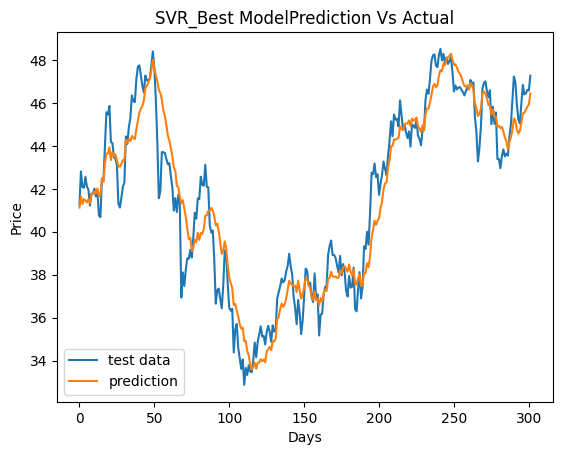

In [179]:
#SVR_Tuning model validation with test data
RMSE_Score, R2_Score = bestModel_validateResult(model_SVRTuning, model_name = "SVR_Best Model")


Benchmark-DTR RMSE:  4.727206323234001
Benchmark-DTR R2 score:  -0.23657979355027758


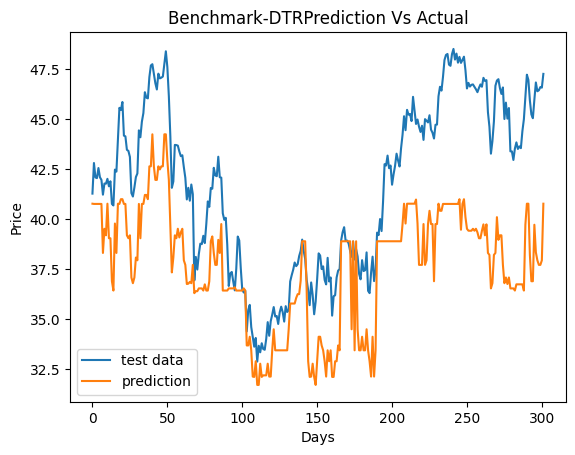

In [180]:
#Benchmarking model validation with test data
RMSE_Score, R2_Score = bestModel_validateResult(model_Benchmark_DTR, model_name = "Benchmark-DTR")

In [181]:
#Benchmark model actual vs prected value
benchmark_BHP_df = value_Compare(model_Benchmark_DTR)
display(benchmark_BHP_df)


,True_value,Predicted_value
0,41.273891,40.768742
1,42.806747,40.757511
2,42.083866,40.757511
3,42.049026,40.757511
4,42.554173,40.757511
...,...,...
297,46.400002,37.933952
298,46.450001,37.704788
299,46.610001,37.704788
300,46.580002,37.933952


In [183]:
#SVM_Tuned model actual vs prected value
BHP_prd_df = value_Compare(model_SVRTuning)
display(BHP_prd_df)

{'C': 1000.0, 'epsilon': 0.1}


,True_value,Predicted_value
0,41.273891,41.127972
1,42.806747,41.652641
2,42.083866,41.292184
3,42.049026,41.520989
4,42.554173,41.453855
...,...,...
297,46.400002,45.547406
298,46.450001,45.683839
299,46.610001,45.830859
300,46.580002,45.924373
